In [ ]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime,os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, MaxPool2D, Activation,BatchNormalization,MaxPooling2D,Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
Dim = 256 
batch_size = 10 
Num_class = 38 
train_steps_per_epoch = 3040 // batch_size 
val_steps_per_epoch = 722 // batch_size



In [ ]:
EPOCHS = 25
INIT_LR = .001
BS = 10
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/content/drive/MyDrive/Plants/Thesis_dataset'
width=256
height=256
depth=3

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

                    
            for image in plant_disease_image_list[:85]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True or image_directory.endswith(".png")==True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Apple___Apple_scab ...
[INFO] Processing Apple___Black_rot ...
[INFO] Processing Apple___Cedar_apple_rust ...
[INFO] Processing Apple___healthy ...
[INFO] Processing Blueberry___healthy ...
[INFO] Processing Cherry_(including_sour)___Powdery_mildew ...
[INFO] Processing Cherry_(including_sour)___healthy ...
[INFO] Processing Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot ...
[INFO] Processing Corn_(maize)___Common_rust_ ...
[INFO] Processing Corn_(maize)___Northern_Leaf_Blight ...
[INFO] Processing Corn_(maize)___healthy ...
[INFO] Processing Grape___Black_rot ...
[INFO] Processing Grape___Esca_(Black_Measles) ...
[INFO] Processing Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ...
[INFO] Processing Grape___healthy ...
[INFO] Processing Orange___Haunglongbing_(Citrus_greening) ...
[INFO] Processing Peach___Bacterial_spot ...
[INFO] Processing Peach___healthy ...
[INFO] Processing Pepper,_bell___Bacterial_spot ...
[INFO] Processing Pepper,_bel

In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [ ]:
np_image_list = np.array(image_list, dtype=np.float16) / 255.0

In [ ]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.25, random_state = 42) 

[INFO] Spliting data to train, test


In [ ]:
y_train.shape

(2364, 38)

In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [ ]:
vgg19_model = tf.keras.applications.vgg19.VGG19(include_top=False, input_tensor=tf.keras.layers.Input(shape=(256, 256, 3)))

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
model = tf.keras.Sequential()
for layer in vgg19_model.layers[:-1]:
  model.add(layer)

In [ ]:
for layer in model.layers:
  layer.trainable=False

In [ ]:
model.add(tf.keras.layers.Flatten())

In [ ]:
model.add(tf.keras.layers.Dense(38, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)       2

In [ ]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
import tensorflow as tf  
checkpoint_filepath='/content/drive/MyDrive/Plants/Thesis_dataset'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=55, verbose=1,
    callbacks=[model_checkpoint_callback]
    )
model.load_weights(checkpoint_filepath)

Epoch 1/55
236/236 [==============================] - 84s 307ms/step - loss: 2.1982 - accuracy: 0.4155 - val_loss: 1.1402 - val_accuracy: 0.6650
Epoch 2/55
236/236 [==============================] - 71s 300ms/step - loss: 1.0340 - accuracy: 0.6822 - val_loss: 0.7905 - val_accuracy: 0.7449
Epoch 3/55
236/236 [==============================] - 62s 263ms/step - loss: 0.7799 - accuracy: 0.7634 - val_loss: 0.5817 - val_accuracy: 0.8211
Epoch 4/55
236/236 [==============================] - 60s 254ms/step - loss: 0.6652 - accuracy: 0.7910 - val_loss: 0.7589 - val_accuracy: 0.7475
Epoch 5/55
236/236 [==============================] - 60s 255ms/step - loss: 0.5777 - accuracy: 0.8207 - val_loss: 0.6571 - val_accuracy: 0.8084
Epoch 6/55
236/236 [==============================] - 61s 257ms/step - loss: 0.4700 - accuracy: 0.8509 - val_loss: 0.4767 - val_accuracy: 0.8566
Epoch 7/55
236/236 [==============================] - 60s 254ms/step - loss: 0.4206 - accuracy: 0.8679 - val_loss: 0.7731 - val_ac

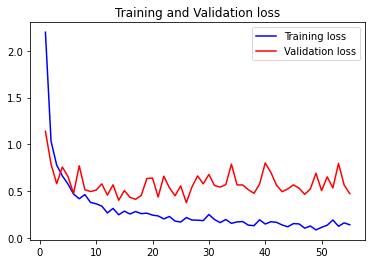

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
testpred = model.predict(x_test)

In [ ]:
LABELS = ['Apple___Apple_scab' ,'Apple___Black_rot' ,'Apple___Cedar_apple_rust',
 'Apple___healthy', 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_' ,'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy' ,'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)' ,'Peach___Bacterial_spot',
 'Peach___healthy' ,'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy' ,'Potato___Early_blight' ,'Potato___Late_blight',
 'Potato___healthy' ,'Raspberry___healthy', 'Soybean___healthy',
 'Squash___Powdery_mildew' ,'Strawberry___Leaf_scorch',
 'Strawberry___healthy' ,'Tomato___Bacterial_spot', 'Tomato___Early_blight',
 'Tomato___Late_blight' ,'Tomato___Leaf_Mold' ,'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score


def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(12, 8))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

#y_pred_test = model.predict(X_train)
# Take the class with the highest probability from the test predictions
#max_y_pred_test = np.argmax(y_pred_test, axis=1)
#max_y_test = np.argmax(y_train_hot, axis=1)

rounded_predictions = np.argmax(testpred, axis=1)
rounded_labels=np.argmax(y_test, axis=1)
show_confusion_matrix(rounded_labels, rounded_predictions)
print(classification_report(rounded_labels, rounded_predictions))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86        25
           1       1.00      0.90      0.95        10
           2       1.00      0.89      0.94        28
           3       0.85      0.92      0.88        25
           4       0.92      1.00      0.96        23
           5       1.00      1.00      1.00        27
           6       1.00      0.96      0.98        24
           7       0.72      1.00      0.84        23
           8       1.00      1.00      1.00        17
           9       1.00      0.52      0.69        23
          10       0.95      0.90      0.92        20
          11       1.00      0.85      0.92        20
          12       0.86      1.00      0.93        19
          13       1.00      1.00      1.00        24
          14       1.00      1.00      1.00        10
          15       1.00      0.96      0.98        23
          16       0.86      0.95      0.90        20
          17       0.96    

In [ ]:
ypred = testpred.argmax(axis=-1)
ytest = y_test.argmax(axis=-1)

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= ['Apple___Apple_scab' ,'Apple___Black_rot' ,'Apple___Cedar_apple_rust',
 'Apple___healthy', 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_' ,'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy' ,'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)' ,'Peach___Bacterial_spot',
 'Peach___healthy' ,'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy' ,'Potato___Early_blight' ,'Potato___Late_blight',
 'Potato___healthy' ,'Raspberry___healthy', 'Soybean___healthy',
 'Squash___Powdery_mildew' ,'Strawberry___Leaf_scorch',
 'Strawberry___healthy' ,'Tomato___Bacterial_spot', 'Tomato___Early_blight',
 'Tomato___Late_blight' ,'Tomato___Leaf_Mold' ,'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (16, 16))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.5f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(ytest, ypred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

ROC AUC score: 0.9484857392674255
